In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Analysis of the SpaceX Mission CRS-11: Booster Return

This project analyzes the CRS-11 mission by SpaceX, conducted in June 2017 to resupply the International Space Station (ISS), using telemetry data obtained through computer vision techniques applied to the company's official broadcast. The data was subsequently processed to detect and correct anomalies, resulting in relevant metrics from the mission. 

The mission involves two types of booster recovery: Return To Launch Site (RTLS) and Autonomous Spaceport Drone Ship (ASDS), with the former being simpler as the booster returns close to the launch site, while the latter is more complex due to the instability of the barge and the need for precise coordination. The RTLS process includes stages such as the main engine cutoff (MECO), stage separation, boostback burn to redirect the rocket, and entry into the atmosphere, where hypersonic phenomena require the engines to reignite to reduce mechanical stresses, culminating in the landing burn and concluding the operations.


## Data Sources

This data was provided by **Shahar603**, who has made the dataset available at [GitHub - Telemetry Data](https://github.com/shahar603/Telemetry-Data). The data is collected from SpaceX live transmissions, and **Shahar603** has used computer vision techniques to extract the telemetry data from SpaceX's live broadcasts.

The data is derived from SpaceX's real-time transmissions during launches and booster landings. Computer vision models were used to automatically process video frames from the livestreams, detecting key metrics like **velocity**, **altitude**, **acceleration**, and more. This allows for accurate tracking of the mission without relying on manual recording methods.

## Datasets

There are two primary datasets used in this analysis:

### 1. Telemetry Data
The telemetry data includes several important columns, each representing a key aspect of the mission’s performance over time. The columns in the **"analysed"** dataset are as follows:

- **time**: The timestamp for each recorded data point, representing the time elapsed since the start of the launch or event.
- **velocity**: The speed of the booster in meters per second (m/s).
- **altitude**: The altitude of the booster above the Earth's surface, measured in meters (m).
- **velocity_x**: The velocity in the x-direction, in meters per second (m/s).
- **velocity_y**: The velocity in the y-direction, in meters per second (m/s).
- **acceleration**: The booster’s acceleration, measured in meters per second squared (m/s²).
- **downrange_distance**: The horizontal distance traveled by the booster from the launch site, in meters (m).
- **angle**: The angle of the booster relative to the horizontal plane, measured in degrees.
- **q**: The dynamic pressure, which is an important metric related to the aerodynamic forces acting on the booster, measured in Pascals (Pa).

These data points help us understand the booster’s performance during the mission, including its velocity, altitude, and trajectory. By analyzing this telemetry data, we can track how the booster is behaving at different stages of the mission, such as ascent, boostback, and landing.

In [72]:
data = pd.read_excel(r"..\data\SpaceX CRS-11\analysed.xlsx")
data.head()

,time,velocity,altitude,velocity_y,velocity_x,acceleration,downrange_distance,angle,q
0,0,0.000,0.000,0.065,0.0,10.487,0.0,90.0,0.000000
1,1,1.944,0.001,1.968,0.0,11.068,0.0,90.0,2.314503
2,2,2.877,0.003,3.871,0.0,11.669,0.0,90.0,5.068054
3,3,5.352,0.007,5.992,0.0,12.158,0.0,90.0,17.532656
4,4,8.230,0.014,8.549,0.0,12.561,0.0,90.0,41.430905


### 2. Event Data
The **"events"** dataset contains specific events that were detected during the mission. The columns in this dataset are as follows:

- **Event**: A description or name of the event (e.g., "Engine Cutoff", "Boostback Start", etc.).
- **Time [s]**: The timestamp at which the event occurred, measured in seconds since the start of the launch.

This dataset helps to contextualize the telemetry data by marking important events during the flight, such as engine burns, stage separation, and landing.

In [115]:
events = pd.read_excel(r"..\data\SpaceX CRS-11\events.xlsx")
events.dropna(inplace=True)

MECO_T = 145 #[S]
BOOSTBACK_START = 161
BOOSTBACK_END = 211
ENTRY_BURN_START = 372
ENTRY_BURN_END = 384
LANDING_START = 429

# Get the flight paths
launch = data[data.time <= MECO_T]
meco = data.iloc[MECO_T]
p0 = data[(data.time >= MECO_T) & (data.time <= BOOSTBACK_START)]
boostback = data[(data.time >= BOOSTBACK_START) & (data.time < BOOSTBACK_END)]
p1 = data[(data.time >= BOOSTBACK_END) & (data.time <= ENTRY_BURN_START)]
entryburn = data[(data.time >= ENTRY_BURN_START) & (data.time < ENTRY_BURN_END)]
p2 = data[(data.time >= ENTRY_BURN_END) & (data.time <= LANDING_START)]
landingburn = data[(data.time >= LANDING_START)]

events_dict = events.set_index('Event')['Time [s]'].to_dict()
events

,Event,Time [s]
0,entry_end,384.0
1,boostback_start,161.0
2,apogee,248.0
3,entry_start,372.0
4,throttle_down_start,50.0
5,maxq,65.0
6,throttle_down_end,74.0
7,meco,145.0
9,boostback_end,211.0
11,landing_start,429.0


# Mission Analysis

In the following sections, we will explore how to analyze and visualize the telemetry data and the associated events to gain insights into the performance of the SpaceX mission.

In [ ]:
# Annotate the current plot
def plot_with_events(x,y, events:dict=None, label=None, ax=None, **kwargs):

    if ax is None:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
    ax.plot(x, y, label=label, color='blue')
    if events is not None:
        for event, t in events.items():
            plt.axvline(t, color='grey', linestyle='--', linewidth=0.7)
            plt.text(t, y.max()*0.3, event, 
                     rotation=90, 
                     ha='right',
                     verticalalignment='bottom', 
                     color='black',
                     fontsize=11, 
                     )
    ax.set(**kwargs)
    ax.legend()
    ax.grid(True)

## Flight Trajectory

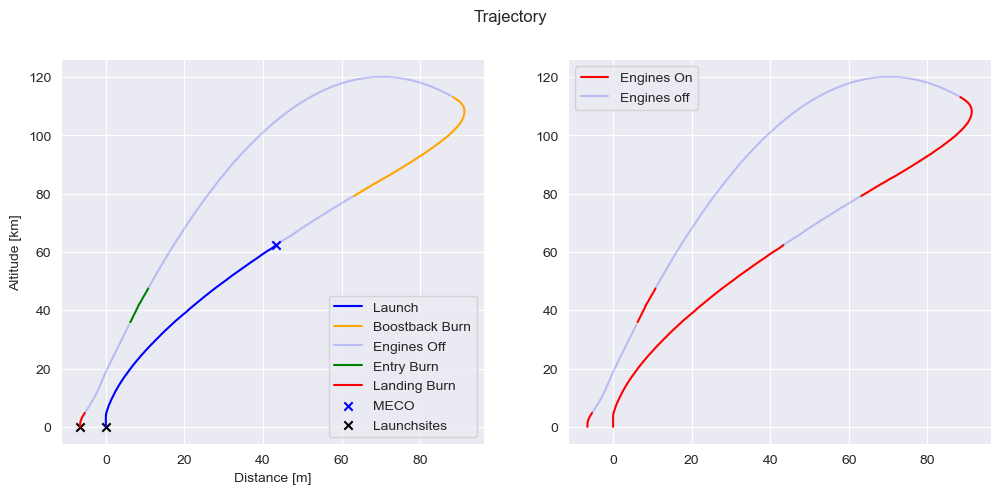

In [ ]:
fig,axs=plt.subplots(1,2, figsize=(12, 5))

# Plot trajectory and events
axs[0].plot(launch.downrange_distance, launch.altitude, label='Launch', color='b')
axs[0].plot(p0.downrange_distance, p0.altitude, color='blue', alpha=0.2)
axs[0].plot(boostback.downrange_distance, boostback.altitude, label='Boostback Burn', color='orange')
axs[0].plot(p1.downrange_distance, p1.altitude, label='Engines Off', color='blue', alpha=0.2)
axs[0].plot(entryburn.downrange_distance, entryburn.altitude, label='Entry Burn', color='green')
axs[0].plot(p2.downrange_distance, p2.altitude, color='blue', alpha=0.2)
axs[0].plot(landingburn.downrange_distance, landingburn.altitude, label='Landing Burn', color='red')
axs[0].scatter(meco.downrange_distance, meco.altitude, label='MECO', marker='x', color='b')
axs[0].scatter([data.iloc[-1].downrange_distance, data.iloc[0].downrange_distance], [0,0], label='Launchsites', marker='x', color='black')

axs[0].legend()
axs[0].set_xlabel("Distance [m]")
axs[0].set_ylabel("Altitude [km]")

axs[1].plot(launch.downrange_distance, launch.altitude,  color='r')
axs[1].plot(p0.downrange_distance, p0.altitude, color='blue', alpha=0.2)
axs[1].plot(boostback.downrange_distance, boostback.altitude, color='r')
axs[1].plot(p1.downrange_distance, p1.altitude,  color='blue', alpha=0.2)
axs[1].plot(entryburn.downrange_distance, entryburn.altitude,  color='r')
axs[1].plot(p2.downrange_distance, p2.altitude, color='blue', alpha=0.2)
axs[1].plot(landingburn.downrange_distance, landingburn.altitude, color='r')
axs[1].plot([], [], color='r', label='Engines On')  # Dummy plot for Engines On
axs[1].plot([], [], color='blue', alpha=0.2, label='Engines off')  # Dummy plot for Engines Off

axs[1].legend()
axs[0].set_xlabel("Distance [m]")
plt.suptitle('Trajectory')

# Velocity Profile

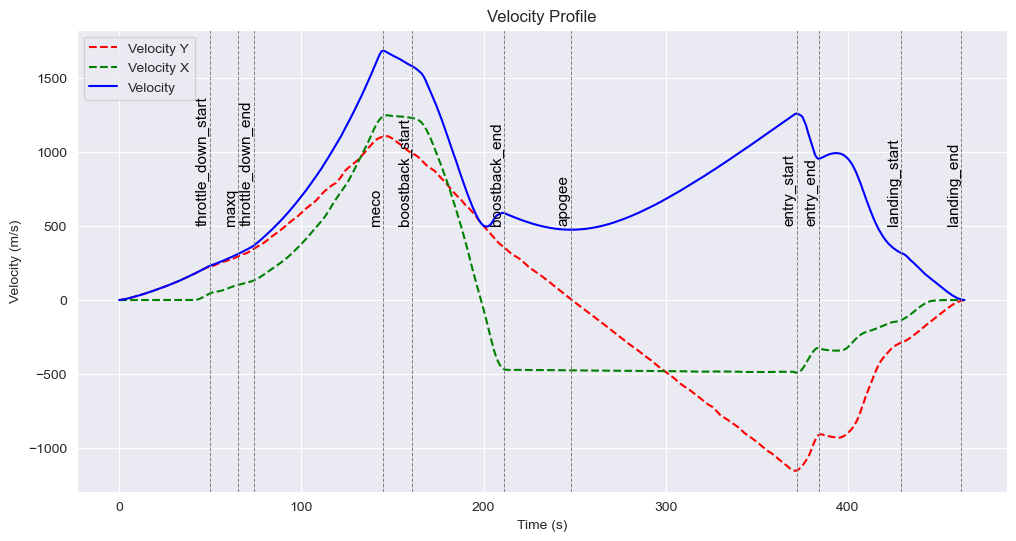

In [124]:
plt.figure(figsize=(12, 6))  # Width, Height in inches
ax=plt.subplot()

ax.plot(data['time'], data['velocity_y'], label='Velocity Y', color='r', linestyle='--')
ax.plot(data['time'], data['velocity_x'], label='Velocity X', color='g', linestyle='--')

plot_with_events(
    x=data['time'],
    y=data['velocity'],
    events=events_dict,
    label='Velocity',
    title='Velocity Profile',
    xlabel='Time (s)',
    ylabel='Velocity (m/s)',
    ax=ax
    )



## Aerodynamic Pressure

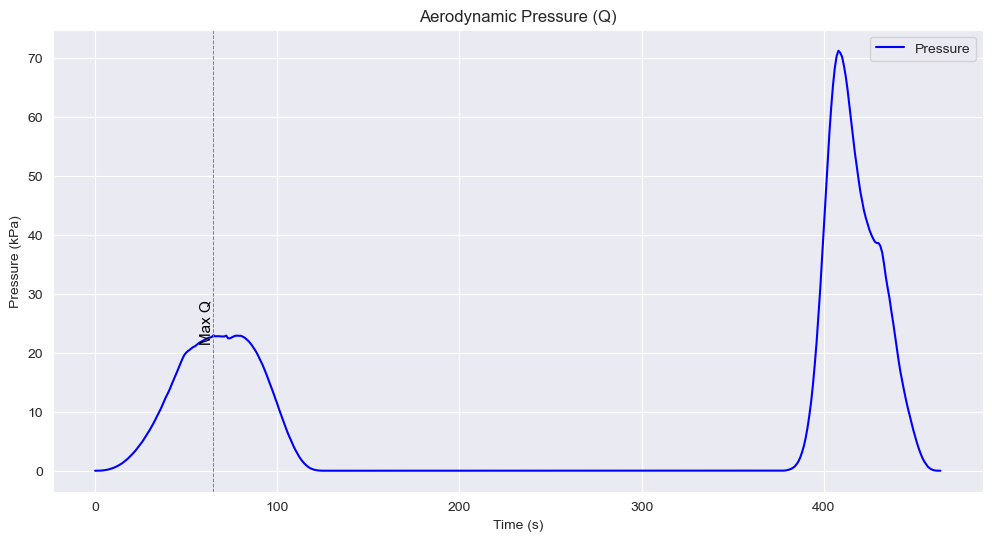

In [121]:
plot_with_events(
    x=data['time'],
    y=data['q']/1000,
    events={'Max Q': events_dict['maxq']},
    title='Aerodynamic Pressure (Q)',
    label='Pressure',
    #color='b',
    xlabel='Time (s)',
    ylabel='Pressure (kPa)'
)

# Altitude

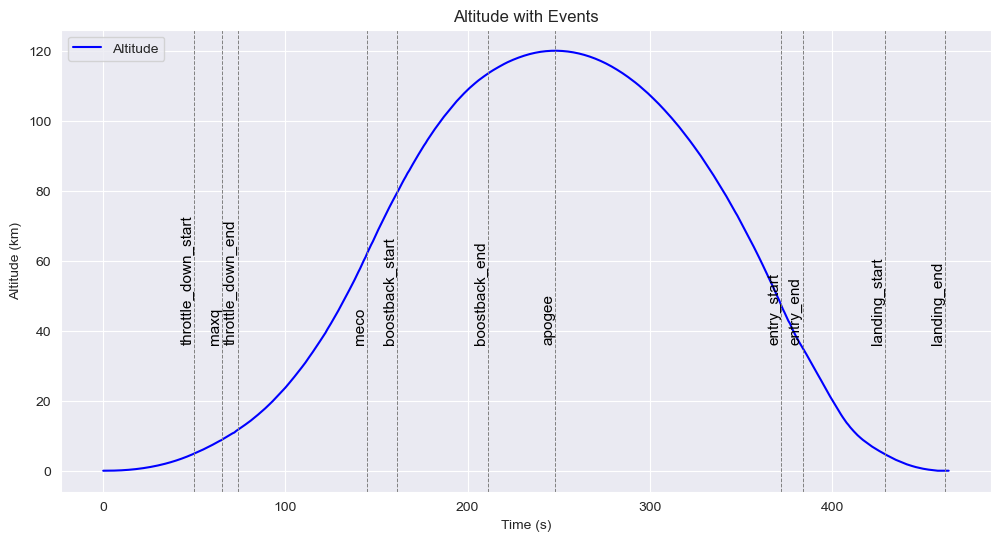

In [122]:
plot_with_events(x=data['time'],
                 y=data['altitude'],
                 label='Altitude',
                 events=events_dict,
                 title='Altitude with Events', 
                 xlabel='Time (s)',
                 ylabel='Altitude (km)'
                 )